# Intro

Dataset link: https://www.kaggle.com/datasets/tysonpo/ice-cream-dataset

Inspiration Notebooks:
- Using Ice Cream Ingredients to Predict Rating: https://www.kaggle.com/code/gcdatkin/using-ice-cream-ingredients-to-predict-rating
- Finding the Best Ice Cream: https://www.kaggle.com/code/kelvintran1998/finding-the-best-ice-cream
- EDA ideas: McDonalds Ice Cream Machines Breaking: https://www.kaggle.com/code/aashidutt3/eda-mcdonalds-ice-cream-machines-breaking

# Loading Data and Libraries

In [1]:
# loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pylab import rcParams
import seaborn as sns
import os
import re

In [2]:
# Get the parent directory of the notebook
notebook_dir = os.path.abspath('')  # This gets the current notebook path
project_root = os.path.dirname(notebook_dir)  # Go one level up if needed

# Change the working directory
os.chdir(project_root)

In [3]:
# reading dataset
df = pd.read_csv("data/intermediate/pre-processed.csv")
print("the dataset has " + str(df.shape[0]) + " observations (ice cream flavors) and " + str(df.shape[1]) + " features " + str([col for col in df.columns]))

the dataset has 241 observations (ice cream flavors) and 5 features ['brand', 'name', 'rating', 'rating_count', 'ingredients']


In [4]:
df.head(10)

,brand,name,rating,rating_count,ingredients
0,BenJerrys,Salted Caramel Core,3.7,208,"CREAM, SKIM MILK, LIQUID SUGAR (SUGAR, WATER),..."
1,BenJerrys,Netflix & Chilll'd™,4.0,127,"CREAM, SKIM MILK, LIQUID SUGAR (SUGAR, WATER),..."
2,BenJerrys,Chip Happens,4.7,130,"CREAM, LIQUID SUGAR (SUGAR, WATER), SKIM MILK,..."
3,BenJerrys,Cannoli,3.6,70,"CREAM, SKIM MILK, LIQUID SUGAR (SUGAR, WATER),..."
4,BenJerrys,Gimme S’more!™,4.5,281,"CREAM, SKIM MILK, WATER, LIQUID SUGAR (SUGAR, ..."
5,BenJerrys,Peanut Butter Half Baked®,4.9,14,"CREAM, LIQUID SUGAR (SUGAR, WATER), SKIM MILK,..."
6,BenJerrys,Berry Sweet Mascarpone,4.6,10,"CREAM, SKIM MILK, WATER, LIQUID SUGAR (SUGAR, ..."
7,BenJerrys,Chocolate Peanut Butter Split,5.0,7,"CREAM, SKIM MILK, LIQUID SUGAR (SUGAR, WATER),..."
8,BenJerrys,Justice ReMix'd ™,4.3,110,"CREAM, LIQUID SUGAR (SUGAR, WATER), SKIM MILK,..."
9,BenJerrys,Boots on the Moooo’n™,4.7,42,"CREAM, LIQUID SUGAR (SUGAR, WATER), SKIM MILK,..."


# Correcting the ingredient list and getting an unique list with all Ingredients

I aim to generate a unique set of ingredients for each ice cream to analyze how ingredient composition affects ratings. By comparing the ingredient lists of the top 10 and bottom 10 rated ice creams, I hope to identify patterns or key differences.

Next, I will use this unique ingredient set to create a dummy matrix as input for machine learning models.

However, before proceeding, I need to resolve various formatting issues in the ingredient lists.

* Data Cleaning

In [5]:
# increasing column character limit for better visualization
pd.set_option('display.max_colwidth', 50000)

In [6]:
# leave the ingredients column in lower case.
df['ingredients_cleaned'] = df['ingredients'].str.lower()
df['ingredients_cleaned'].head()

0                                   cream, skim milk, liquid sugar (sugar, water), water, brown sugar, sugar, milk, wheat flour, egg yolks, corn syrup, eggs, butter (cream, salt), butteroil, pectin, sea salt, soybean oil, vanilla extract, guar gum, soy lecithin, baking powder (sodium acid pyrophosphate, sodium bicarbonate, corn starch, monocalcium phosphate), baking soda, salt, carrageenan, lactase
1                                                                          cream, skim milk, liquid sugar (sugar, water), water, sugar, peanuts, wheat flour, canola oil, egg yolks, corn starch, peanut oil, cocoa powder, salt, soybean oil, invert cane sugar, milk fat, eggs, egg whites, guar gum, soy lecithin, tapioca starch, baking soda, carrageenan, vanilla extract, barley malt, malted barley flour
2    cream, liquid sugar (sugar, water), skim milk, water, sugar, cocoa (processed with alkali), potato, coconut oil, corn syrup solids, soybean oil, egg yolks, rice starch, sunflower oil, barley 

In [7]:
# checking for all unique ingredients to find errors
all_ingredients = set()

for row in df.iterrows():
    ingredients = df.loc[row[0], 'ingredients_cleaned']
    for ingredient in ingredients.split(','):
        if ingredient not in all_ingredients:
            all_ingredients.add(ingredient)

# iterrows(): returns a tuple containing the index and the rest of the row

In [8]:
#printing the all_ingredients set to check formatting problems
all_ingredients

{'  water',
 ' acesulfame potassium',
 ' almond extract',
 ' almonds',
 ' almonds roasted in vegetable oil',
 ' and/or baking soda',
 ' and/or calcium phosphate',
 ' and/or canola oil',
 ' and/or palm oil',
 ' and/or sunflower oil)',
 ' anhydrous milkfat',
 ' annatto (color)',
 ' annatto (for color)',
 ' apple juice',
 ' artificial color',
 ' artificial flavor',
 ' artificial flavoring',
 ' artificial flavors',
 ' ascorbic acid',
 ' baking powder',
 ' baking powder (sodium acid pyrophosphate',
 ' baking soda',
 ' baking soda and/or calcium phosphate',
 ' baking soda. contains milk',
 ' balsamic vinegar (red wine vinegar',
 ' banana puree',
 ' bananas',
 ' barley malt',
 ' beet juice (for color)',
 ' belgian chocolate',
 ' black carrot concentrate (for color)',
 ' black cherries',
 ' black raspberries',
 ' black raspberry puree',
 ' blackberry juice concentrate',
 ' bleached wheat flour',
 ' blue 1',
 ' blue 1 lake',
 ' blue 2',
 ' blue 2 lake',
 ' blueberries',
 ' blueberry puree conce

We can identify several issues with the ingredient descriptions which can make the data harder to clean and standardize. These issues include:

1) Parentheses capturing content:
The descriptions often include parentheses that capture sub-ingredients or additional details, which need to be handled carefully to extract meaningful information.

2) Logical Operators (AND/OR):
The use of logical terms like "AND" and "OR" in ingredient lists can create ambiguity, especially when determining whether multiple ingredients are required or optional.

3) Special Characters:
The presence of special characters (e.g., commas, semicolons, slashes) can complicate parsing and analysis, as they may not consistently represent separators or relationships between ingredients.

4) Excess Whitespace:
Inconsistent or excessive use of whitespace (e.g., extra spaces, tabs, or newlines).

4) Synonyms or Equivalent Ingredients:
The use of synonyms or alternative names for the same ingredient (e.g., "sugar" vs. "cane sugar") can lead to duplication or inconsistency.

Addressing these issues is crucial for ensuring accurate analysis and modeling of the ingredient data.

In [9]:
# using regex module to eliminate content inside parentheses '()'
df['ingredients_cleaned'] = df['ingredients_cleaned'].str.replace(r'\([^()]*\)',"", regex=True)
df['ingredients_cleaned'].head() # checking

0                                                                                                            cream, skim milk, liquid sugar , water, brown sugar, sugar, milk, wheat flour, egg yolks, corn syrup, eggs, butter , butteroil, pectin, sea salt, soybean oil, vanilla extract, guar gum, soy lecithin, baking powder , baking soda, salt, carrageenan, lactase
1                                                   cream, skim milk, liquid sugar , water, sugar, peanuts, wheat flour, canola oil, egg yolks, corn starch, peanut oil, cocoa powder, salt, soybean oil, invert cane sugar, milk fat, eggs, egg whites, guar gum, soy lecithin, tapioca starch, baking soda, carrageenan, vanilla extract, barley malt, malted barley flour
2    cream, liquid sugar , skim milk, water, sugar, cocoa , potato, coconut oil, corn syrup solids, soybean oil, egg yolks, rice starch, sunflower oil, barley malt, cocoa powder, wheat flour, milk, salt, soy lecithin, yeast extract, natural flavor, guar gum, sea salt, m

In [10]:
# using regex module to remove excess of whitespace
df['ingredients_cleaned'] = df['ingredients_cleaned'].str.replace(r'\s*,\s*',", ", regex=True)
df['ingredients_cleaned'].head() # checking results

0                                                                                                             cream, skim milk, liquid sugar, water, brown sugar, sugar, milk, wheat flour, egg yolks, corn syrup, eggs, butter, butteroil, pectin, sea salt, soybean oil, vanilla extract, guar gum, soy lecithin, baking powder, baking soda, salt, carrageenan, lactase
1                                                  cream, skim milk, liquid sugar, water, sugar, peanuts, wheat flour, canola oil, egg yolks, corn starch, peanut oil, cocoa powder, salt, soybean oil, invert cane sugar, milk fat, eggs, egg whites, guar gum, soy lecithin, tapioca starch, baking soda, carrageenan, vanilla extract, barley malt, malted barley flour
2    cream, liquid sugar, skim milk, water, sugar, cocoa, potato, coconut oil, corn syrup solids, soybean oil, egg yolks, rice starch, sunflower oil, barley malt, cocoa powder, wheat flour, milk, salt, soy lecithin, yeast extract, natural flavor, guar gum, sea salt, milkfat

In [11]:
# since this will be a repetitive task, let's create a function to split, correct, and process the text.
def ingredients_processing(text):
    bool = df['ingredients_cleaned'].str.contains(text, regex=False)
    val_to_replace = df['ingredients_cleaned'][bool].str.split(text).str[0]
    df['ingredients_cleaned'] = df['ingredients_cleaned'].mask(bool, val_to_replace)
    return

In [12]:
# problematic text: spliting by and selecting only first column
problematic_text_ingredients_list = ['\ncontains', 'contains', '.']

for text in problematic_text_ingredients_list:
    ingredients_processing(text)

In [13]:
# observations with ':' problem - spliting by and selecting only second column
bool = df['ingredients_cleaned'].str.contains(":", regex=False)
val_to_replace = df['ingredients_cleaned'][bool].str.split(": ").str[1] # here we will use the second column, not the first
df['ingredients_cleaned'] = df['ingredients_cleaned'].mask(bool, val_to_replace)

df['ingredients_cleaned'] #checking results (It looks like all the rows are blank, but in reality, the last row has more ingredients. Scroll to the right to check.)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     cream, skim milk, liquid sugar, water, brown sugar, sugar, milk, wheat flour, egg yolks, corn syrup, eggs, butter, butteroil, pectin, sea salt, soybean oil, vanilla extract, guar gum, soy lecithin, baking powder, baking soda, salt, carrageenan, lactase
1                                                                                                    

* Data Treatment: Manual Correction

In [14]:
# checking tests (all tests needs to be False)

#df[df['ingredients_cleaned'].str.contains("mono and diglycerides", regex=False)] == True
#df[df['ingredients_cleaned'].str.contains(" and ", regex=False)] == True
#df[df['ingredients_cleaned'].str.contains("and/or", regex=False)] == True
#df[df['ingredients_cleaned'].str.contains("†", regex=False)] == True
#df[df['ingredients_cleaned'].str.contains("*", regex=False)] == True
#df[df['ingredients_cleaned'].str.contains(")", regex=False)] == True
#df[df['ingredients_cleaned'].str.contains("/", regex=False)] == True
#df[df['ingredients_cleaned'].str.contains("vanilla ice cream", regex=False) == True]

In [15]:
# treating the problem with 'mono and diglycerides'
df['ingredients_cleaned'] = df['ingredients_cleaned'].str.replace("mono and diglycerides", "monoglycerides, diglycerides", regex=False)

In [16]:
# treating the problem with 'and/or' + 'and':
unwanted_text = [' and ', 'and/or']

for word in unwanted_text:
    df['ingredients_cleaned'] = df['ingredients_cleaned'].str.replace(word, ',', regex=False)

In [17]:
# replacing strange text to ''
unwanted_text = ['†', ')' , 'organic', 'pasteurized','(sugar', 'unbleached', 'enriched', 'unenriched', 'vanilla ice cream', 'coffee ice cream', 'white chocolate ice cream', 
'unsweetened', 'whole', 'pieces', 'concentrates', 'concentrate', 'juice', 'pasteurized', 'puree',  'vegetable s', ' lake']

for word in unwanted_text:
    df['ingredients_cleaned'] = df['ingredients_cleaned'].str.replace(word, '', regex=False)

In [18]:
# replacing strange text to ' '
unwanted_text = ['*', '/']

for word in unwanted_text:
    df['ingredients_cleaned'] = df['ingredients_cleaned'].str.replace(word, ' ', regex=False)

### Word Correcting

First Attempt: PorterStemmer() and stem() Function
- The PorterStemmer() and stem() functions break down words into their root forms, helping to reduce redundancy (e.g., "egg" vs. "eggs"). These libraries, based on common English language suffixes, can be effective for standardizing text. However, the results were not consistently satisfactory.

<br>

Second Attempt: Manual Approach
- I’m feeling a bit frustrated with the need to check everything manually. I initially tried using the PorterStemmer to automate the process, but after running several tests, I’m not confident in this method due to the high number of errors it generates.

In [19]:
# Creating a dictionary
word_correcting = {"reese's mini ": "reese's peanut butter", "reese's peanut butter cup ": "reese's peanut butter", "reese's peanut butter cups": "reese's peanut butter",
                   "reese's peanut butter sauce": "reese's peanut butter", "reese's peanut butter swirl": "reese's peanut butter", 'almonds roasted in vegetable oil': 'almonds',
                   'roasted almonds': 'almonds', 'dried apples': 'apple', 'apples': 'apple', 'artificial color lake': 'artificial color', 'color added': 'artificial color',
                   'annatto': 'artificial color', 'blue 1': 'artificial color', 'blue 1': 'artificial color', 'blue 1 lake': 'artificial color', 'blue 2': 'artificial color',
                   'blue 2 lake': 'artificial color', 'yellow 5': 'artificial color', 'yellow 5 lake': 'artificial color', 'yellow 6': 'artificial color', 'yellow 6 lake': 'artificial color',
                   'red 40': 'artificial color', 'red 40 lake': 'artificial color', 'reb a': 'artificial color', 'artificial color lake': 'artificial color',
                   'artificial flavoring': 'artificial flavor', 'artificial flavors': 'artificial flavor', 'banana puree': 'banana', 'bananas': 'banana', 'black carrot s': 'black carrot',
                   'black raspberry puree': 'black raspberry', 'black raspberries': 'black raspberry', 'blueberries': 'blueberry', 'butteroil': 'butter', 'butterfat': 'butter',
                   'butter oil': 'butter', 'dried cane syrup': 'cane syrup', 'caramelized sugar': 'caramel', 'caramel color': 'caramel', 'caramel flavor': 'caramel',
                   'caramel swirl': 'caramel', 'caramel syrup': 'caramel', 'caramelized sugar syrup': 'caramelized sugar', 'carob bean': 'carob bean gum', 'carob gum': 'carob bean gum',
                   'cheese cultures': 'cheese culture', 'cherries': 'cherry', 'cherry': 'cherry', 'cherry puree': 'cherry', 'cherry concentrate': 'cherry', 'cherry juice concentrate': 'cherry',
                   'chocolate chip cookies': 'chocolate', 'chocolate chips': 'chocolate', 'chocolate cookie pieces': 'chocolate', 'chocolate flavored coating': 'chocolate', 'chocolate liquor':
                   'chocolate', 'chocolate processed with alkali': 'chocolate', 'chocolatey chips': 'chocolate', 'milk chocolate candies': 'chocolate',
                   'milk chocolate': 'chocolate','dark chocolate': 'chocolate', 'semi-sweet chocolate chunks': 'chocolate', 'chocolaty coated cone': 'chocolatey coated cone',
                   'black cocoa processed with alkali': 'cocoa powder', 'dutched cocoa': 'cocoa powder', 'coconut concentrate': 'coconut', 'coconut cream': 'coconut', 'coconut extract': 'coconut',
                   'desiccated coconut': 'coconut', 'coffee extract': 'coffee', 'coffee extract concentrate': 'coffee', 'condensed skim milk': 'condensed milk',
                   'evaporated milk': 'condensed milk', 'sweetened condensed milk': 'condensed milk', 'sweetened condensed skim milk': 'condensed milk', 'corn syrup solids': 'corn syrup',
                   'high fructose corn syrup': 'corn syrup', 'corn starch': 'cornstarch', 'modified corn starch': 'cornstarch', 'modified food starch': 'cornstarch',
                   'modified cornstarch': 'cornstarch', 'eggs': 'egg', 'whole egg': 'egg', 'whole eggs': 'egg', 'egg whites': 'egg white',
                   'egg yolks': 'egg yolk', 'guar': 'guar gum', 'ground heath toffee': 'heath toffee bar', 'hibiscus flower': 'hibiscus', 'hibiscus powder': 'hibiscus',
                   'invert cane sugar': 'inverted sugar syrup', 'invert sugar': 'inverted sugar syrup', 'lactase enzyme': 'lactase', 'lemon juice': 'lemon', 'lemon juice concentrate': 'lemon',
                   'locust bean': 'locust bean gum', 'dry malt extract': 'malt extract', 'maltitol': 'maltitol syrup', 'corn maltodextrin': 'maltodextrin', 'mango puree': 'mango',
                   'mangos': 'mango', 'organic milk': 'milk', 'anhydrous milkfat': 'milk fat', 'milkfat': 'milk fat', 'nonfat milk solids': 'milk powder', 'nonfat dry milk': 'milk powder',
                   'whole milk powder': 'milk powder', 'skim milk powder': 'milk powder', 'natural flavors': 'natural flavor', 'rolled oats': 'oats', 'vitamin a palm oil oilitate': 'palm oil',
                   '^palm$': 'palm oil', 'palm': 'palm oil', 'palm kernel': 'palm oil', 'palm kernel oil': 'palm oil', 'partially defatted peanut flour': 'peanut', 'roasted peanuts': 'peanut',
                   'peppermint bark': 'peppermint', 'peppermint extract': 'peppermint', 'peppermint oil': 'peppermint', 'peppermint twists candy': 'peppermint', 'pistachio paste': 'pistachio',
                   'pistachios': 'pistachio', 'raspberries': 'raspberry', 'raspberry swirl': 'raspberry', 'sea salt': 'salt', 'organic skim milk': 'skim milk', 'lactose reduced skim milk': 'skim milk',
                   'nonfat milk': 'skim milk', 'soy lecithin': 'soybean lecithin', 'soybean lecithin natural flavor': 'soybean lecithin','soybean oils': 'soybean oil',
                   'expeller pressed soybean oil': 'soybean oil', 'spice': 'spices', 'strawberries': 'strawberry', 'strawberry swirl': 'strawberry',
                   'powdered sugar': 'sugar', 'cane sugar': 'sugar', 'liquid sugar': 'sugar syrup', 'sunflower oils': 'sunflower oil', 'tapioca flour': 'tapioca', 'tapioca starch': 'tapioca',
                   'tapioca syrup': 'tapioca', 'tara': 'tara gum', 'thiamin mononitrate': 'thiamine mononitrate', 'vanilla bean seeds': 'vanilla', 'vanilla beans': 'vanilla',
                   'vanilla extract': 'vanilla', 'ground vanilla': 'vanilla', 'processed vanilla': 'vanilla', 'vegetable gums': 'vegetable gum', 'vegetable oil coating': 'vegetable oil',
                   'waffle cone': 'waffle cone pieces', 'un wheat flour': 'wheat flour', 'bleached wheat flour': 'wheat flour', 'whey protein concentrate': 'whey',
                   'milk protein concentrate': 'whey', 'whey protein': 'whey', 'milk protein': 'whey', 'heavy cream': 'cream', 'cheesecake with graham crust': 'cheesecake', 'cheesecake base': 'cheesecake'
}

In [20]:
# using the dictionary to correct wrong words
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(word_correcting, regex=True)

In [21]:
# making other corrections manually 
# problems like repeated words and excess of whitespace
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(' , ', ', ') # trim excess of whitespace
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(' , ', ', ') # trim excess of whitespace
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(',,', ', ') # trim excess of comma
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(r'"', '') # trim quotation marks
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'gum gum', value='gum', regex=True) # duplicated gum words
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'oil oil', value='oil', regex=True) # duplicated oil words
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'syrup syrup', value='syrup', regex=True) # duplicated syrup words
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'peanuts', value='peanut', regex=True)
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'palm oil kernel oil', value='palm oil', regex=True)
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'palm oil kernel', value='palm oil', regex=True)
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'vitamin a palm oilitate', value='vitamin a palmitate', regex=True)
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'cocoa processed with alkali', value='cocoa powder', regex=True)
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r', cocoa,', value=', cocoa powder,', regex=True)
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r', cocoa,', value=', cocoa powder,', regex=True) # yeah... i really need to do this 2x
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'spicess', value='spices', regex=True)
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'soybean lecithin natural flavor', value='soybean lecithin', regex=True)
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r' with graham crust', value='', regex=True) #for some reason, the dict method isnt working
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'^\s*,\s*', value='', regex=True) # trim ingredient list wich starts with ','
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'^\s+', value='', regex=True) # trim ingredient list wich starts with whitespace
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'\s*,\s*', value=', ', regex=True) # trim leading and trailing whitespace
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r',\s,\s', value=', ', regex=True) # trim excess of comma
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'\s{2,}', value='', regex=True) # trim excess of whitespace
df['ingredients_cleaned'] = df['ingredients_cleaned'].replace(to_replace=r'\s+$', value='', regex=True) # remove all whitespaces at the end of a string
df = df.drop('ingredients', axis=1)

In [29]:
#df_copy = df.copy()
df = df_copy.copy()

In [30]:
df

,brand,name,rating,rating_count,ingredients_cleaned
0,BenJerrys,Salted Caramel Core,3.7,208,"cream, skim milk, sugar syrup, water, brown sugar, sugar, milk, wheat flour, egg yolk, corn syrup, egg, butter, butter, pectin, salt, soybean oil, vanilla, guar gum, soybean lecithin, baking powder, baking soda, salt, carrageenan, lactase"
1,BenJerrys,Netflix & Chilll'd™,4.0,127,"cream, skim milk, sugar syrup, water, sugar, peanut, wheat flour, canola oil, egg yolk, cornstarch, peanut oil, cocoa powder, salt, soybean oil, inverted sugar syrup, milk fat, egg, egg white, guar gum, soybean lecithin, tapioca, baking soda, carrageenan, vanilla, barley malt, malted barley flour"
2,BenJerrys,Chip Happens,4.7,130,"cream, sugar syrup, skim milk, water, sugar, cocoa powder, potato, coconut oil, corn syrup, soybean oil, egg yolk, rice starch, sunflower oil, barley malt, cocoa powder, wheat flour, milk, salt, soybean lecithin, yeast extract, natural flavor, guar gum, salt, milk fat, vanilla, enzymes, carrageenan, baking soda"
3,BenJerrys,Cannoli,3.6,70,"cream, skim milk, sugar syrup, water, corn syrup, coconut oil, sugar, cane syrup, egg yolk, wheat flour, milk, cocoa powder, natural flavor, guar gum, soybean lecithin, butter, natural flavor, locust bean gum, salt, citric acid, vanilla, soybean oil, tapioca, lactic acid, carrageenan"
4,BenJerrys,Gimme S’more!™,4.5,281,"cream, skim milk, water, sugar syrup, sugar, canola oil, soybean oil, egg yolk, corn syrup, wheat flour, coconut oil, cornstarch, cocoa powder, corn syrup, cocoa powder, graham flour, salt, egg white, butter, tapioca, guar gum, soybean lecithin, baking soda, natural flavor, molasses, honey, vanilla, pectin, caramel syrup, carrageenan"
...,...,...,...,...,...
236,Breyers,CINNABON®,4.0,28,"milk, corn syrup, sugar, brown sugar, soybean oil, water, butter, cream, salt, corn syrup, spices, salt, soybean lecithin, vanilla, cane syrup, wheat flour, coconut oil, water, butter, cream, salt, molasses, sodium bicarbonate, spices, corn syrup, soybean lecithin, salt, fructose, coconut oil, whey, cream, vegetable gum, guar gum, carob bean gum, monoglycerides, diglycerides, natural flavor"
237,Breyers,CarbSmart™ Caramel Swirl Bar,4.7,18,"milk, water, caramel, sugar, water, corn syrup, corn syrup, milk powder, butter, cream, salt, salt, molasses, pectin, soybean lecithin, natural flavor, potassium sorbate, sodium citrate, lactic acid, maltitol syrup, polydextrose, coconut oil, whey, glycerin, cream, soluble corn fiber, vegetable gum, carob bean gum, guar gum, caramel, monoglycerides, diglycerides, natural flavor, acesulfame potassium, sucralose"
238,Breyers,Layered Dessert S'mores,2.5,31,"milk, corn syrup, sugar, wheat flour, butter, cream, salt, palm oil, corn syrup, skim milk, water, rice flour, natural flavor, salt, wheat flour, sugar, palm oil, molasses, spices, salt, baking soda, natural flavor, soybean lecithin, fructose, coconut oil, cocoa powder, whey, cream, vegetable gum, guar gum, carob bean gum, monoglycerides, diglycerides, natural flavor, vanilla"
239,Breyers,Layered Dessert Peach Cobbler,3.2,38,"milk, corn syrup, wheat flour, wheat flour, niacin, reduced iron, thiamine mononitrate, riboflavin, folic acid, sugar, butter, cream, salt, canola oil, milk powder, salt, sodium bicarbonate, peaches, fructose, coconut oil, sugar, whey, cream, vegetable gum, guar gum, carob bean gum, tara gum, monoglycerides, diglycerides, natural flavor, vanilla, artificial color, vanilla"


In [31]:
# the function title don't handle all edge cases (e.g., words with apostrophes or hyphens).
def capitalize_after_whitespace(text):
    # Split the text into words
    words = text.split(' ')
    # Capitalize the first letter of each word
    capitalized_words = [word.capitalize() for word in words]
    # Join the words back into a single string
    return ' '.join(capitalized_words)

In [ ]:
# correcting Ice Cream names 
df['name'] = df['name'].replace(to_replace=r'[™®©’]', value='', regex=True) # Removing Special Characters in Ice Cream name
df['name'] = df['name'].apply(capitalize_after_whitespace) # lower all capitalized words

In [33]:
df

,brand,name,rating,rating_count,ingredients_cleaned
0,BenJerrys,Salted Caramel Core,3.7,208,"cream, skim milk, sugar syrup, water, brown sugar, sugar, milk, wheat flour, egg yolk, corn syrup, egg, butter, butter, pectin, salt, soybean oil, vanilla, guar gum, soybean lecithin, baking powder, baking soda, salt, carrageenan, lactase"
1,BenJerrys,Netflix & Chilll'd,4.0,127,"cream, skim milk, sugar syrup, water, sugar, peanut, wheat flour, canola oil, egg yolk, cornstarch, peanut oil, cocoa powder, salt, soybean oil, inverted sugar syrup, milk fat, egg, egg white, guar gum, soybean lecithin, tapioca, baking soda, carrageenan, vanilla, barley malt, malted barley flour"
2,BenJerrys,Chip Happens,4.7,130,"cream, sugar syrup, skim milk, water, sugar, cocoa powder, potato, coconut oil, corn syrup, soybean oil, egg yolk, rice starch, sunflower oil, barley malt, cocoa powder, wheat flour, milk, salt, soybean lecithin, yeast extract, natural flavor, guar gum, salt, milk fat, vanilla, enzymes, carrageenan, baking soda"
3,BenJerrys,Cannoli,3.6,70,"cream, skim milk, sugar syrup, water, corn syrup, coconut oil, sugar, cane syrup, egg yolk, wheat flour, milk, cocoa powder, natural flavor, guar gum, soybean lecithin, butter, natural flavor, locust bean gum, salt, citric acid, vanilla, soybean oil, tapioca, lactic acid, carrageenan"
4,BenJerrys,Gimme Smore!,4.5,281,"cream, skim milk, water, sugar syrup, sugar, canola oil, soybean oil, egg yolk, corn syrup, wheat flour, coconut oil, cornstarch, cocoa powder, corn syrup, cocoa powder, graham flour, salt, egg white, butter, tapioca, guar gum, soybean lecithin, baking soda, natural flavor, molasses, honey, vanilla, pectin, caramel syrup, carrageenan"
...,...,...,...,...,...
236,Breyers,Cinnabon,4.0,28,"milk, corn syrup, sugar, brown sugar, soybean oil, water, butter, cream, salt, corn syrup, spices, salt, soybean lecithin, vanilla, cane syrup, wheat flour, coconut oil, water, butter, cream, salt, molasses, sodium bicarbonate, spices, corn syrup, soybean lecithin, salt, fructose, coconut oil, whey, cream, vegetable gum, guar gum, carob bean gum, monoglycerides, diglycerides, natural flavor"
237,Breyers,Carbsmart Caramel Swirl Bar,4.7,18,"milk, water, caramel, sugar, water, corn syrup, corn syrup, milk powder, butter, cream, salt, salt, molasses, pectin, soybean lecithin, natural flavor, potassium sorbate, sodium citrate, lactic acid, maltitol syrup, polydextrose, coconut oil, whey, glycerin, cream, soluble corn fiber, vegetable gum, carob bean gum, guar gum, caramel, monoglycerides, diglycerides, natural flavor, acesulfame potassium, sucralose"
238,Breyers,Layered Dessert S'mores,2.5,31,"milk, corn syrup, sugar, wheat flour, butter, cream, salt, palm oil, corn syrup, skim milk, water, rice flour, natural flavor, salt, wheat flour, sugar, palm oil, molasses, spices, salt, baking soda, natural flavor, soybean lecithin, fructose, coconut oil, cocoa powder, whey, cream, vegetable gum, guar gum, carob bean gum, monoglycerides, diglycerides, natural flavor, vanilla"
239,Breyers,Layered Dessert Peach Cobbler,3.2,38,"milk, corn syrup, wheat flour, wheat flour, niacin, reduced iron, thiamine mononitrate, riboflavin, folic acid, sugar, butter, cream, salt, canola oil, milk powder, salt, sodium bicarbonate, peaches, fructose, coconut oil, sugar, whey, cream, vegetable gum, guar gum, carob bean gum, tara gum, monoglycerides, diglycerides, natural flavor, vanilla, artificial color, vanilla"


In [35]:
# saving results to csv to next code (icecream-p3-model.ipynb)
processed_csv_path = os.path.join(project_root, 'data', 'intermediate', 'processed.csv')
df.to_csv(processed_csv_path, index=False, header=True, encoding='cp1252')

# Classifying ingredients list into groups

* Data Treatment: unique ingredients list

In [36]:
# convert the ingredients list in a python set
all_ingredients = set()

for row in df.iterrows():
    ingredient_list = df.loc[row[0], 'ingredients_cleaned'].split(', ')
    for ingredient in ingredient_list:
        if ingredient not in all_ingredients:
            all_ingredients.add(ingredient)

In [37]:
#checking the unique ingredients list (set datatype)
all_ingredients

{'acesulfame potassium',
 'almond extract',
 'almond milk',
 'almonds',
 'apple',
 'artificial color',
 'artificial flavor',
 'ascorbic acid',
 'baking powder',
 'baking soda',
 'balsamic vinegar',
 'banana',
 'barley malt',
 'beet',
 'belgian chocolate',
 'black carrot',
 'black cherry',
 'black raspberry',
 'blackberry',
 'blueberry',
 'bourbon',
 'brown sugar',
 'butter',
 'calcium carbonate',
 'calcium phosphate',
 'cane syrup',
 'canola oil',
 'caramel',
 'caramel syrup',
 'carnauba wax',
 'carob bean gum',
 'carrageenan',
 'carrot',
 'carrot powder',
 'cellulose gum',
 'cheese culture',
 'cheesecake',
 'cherry',
 'chocolate',
 'chocolate cookie',
 'chocolatey coated cone',
 'chocolatey coated peanut',
 'cinnamon',
 'citric acid',
 'cloves',
 'cocoa butter',
 'cocoa powder',
 'coconut',
 'coconut oil',
 'coffee',
 'condensed milk',
 'cone',
 "confectioner's glaze",
 'corn oil',
 'corn syrup',
 'cornstarch',
 'cottonseed oil',
 'cream',
 'cream cheese',
 'cream of tartar',
 'dextri

In [38]:
unique_ingredients_lenght = len(all_ingredients)

print("There are " + str(unique_ingredients_lenght) + " unique ingredients")

There are 199 unique ingredients


* Data Treatment: classifying ingredients into categories

In [39]:
# create a new column classifying ingredients according to fat, milk/water, sweetening, flavor, dye and other to generate filtered lists
categories = {
    'colorants': [
        'artificial color', 'black carrot', 'red cabbage', 'carrot powder', 'vegetablecolor'
    ],
    'fats_and_oils': [
        'butter', 'canola oil', 'carnauba wax', 'cocoa butter', 'coconut oil', 
        'corn oil', 'cottonseed oil', 'cream', 'hydrogenated vegetable oil', 
        'milk fat', 'palm oil', 'peanut oil', 'safflower oil', 'soybean oil', 
        'sunflower oil', 'vegetable oil'
    ],
    'flavors': [
        'almond extract', 'almonds', 'apple', 'balsamic vinegar', 'banana', 
        'belgian chocolate', 'black cherry', 'black raspberry', 'blackberry', 
        'blueberry', 'bourbon', 'carrot', 'cheesecake', 'cherry', 'chocolate', 
        'chocolate cookie', 'chocolatey coated cone', 'chocolatey coated peanut', 
        'cinnamon', 'cloves', 'cocoa powder', 'coconut', 'coffee', 'cone', 
        "confectioner's glaze", 'cream cheese', 'fruit', 'fudge coating', 
        'fudge covered waffle cone pieces', 'fudge swirl', 'ginger', 'graham crumb', 
        'graham flour', 'grape', 'green tea', 'hazelnuts', 'heath toffee bar', 
        'hibiscus', 'lemon', 'lemon oil', 'lemon peel', 'lime', 
        "m&m's minis chocolate with cocoa butter", 'malted barley flour', 'mango', 
        'matcha green tea', 'mint leaf extractives', 'natural flavor', 'nutmeg', 
        'oakwood extract', 'oats', 'orange', 'oreo cookie', 'peaches', 'peanut', 
        'peanut butter', 'peanut extract', 'peanut flour', 'pecans', 'peppermint', 
        'pineapple', 'pistachio', 'plum', 'pumpkin', 'raisins', 'raspberry', 
        "reese's peanut butter", 'rum', 'salt', 'snickers', 'spices', 'strawberry', 
        'sweetened lemon zest', 'toffee', 'vanilla', 'vermouth', 'waffle cone pieces', 
        'walnuts', 'wheat bran', 'wheat germ', 'wheat graham flour', 'whiskey', 'wine'
    ],
    'dairy_and_alternatives': [
        'almond milk', 'condensed milk', 'milk', 'milk powder', 'skim milk', 
        'sweetened condensed milk', 'water', 'whey', 'lactose'
    ],
    'sweeteners': [
        'acesulfame potassium', 'barley malt', 'beet', 'brown sugar', 'cane syrup', 
        'caramel', 'caramel syrup', 'corn syrup', 'dextrin', 'dextrose', 'erythritol', 
        'fructose', 'honey', 'inverted sugar syrup', 'maltitol syrup', 'maltodextrin', 
        'maple syrup', 'molasses', 'polydextrose', 'sorbitol', 'sucralose', 'sugar', 
        'sugar syrup', 'malt extract'
    ],
    'stabilizers_and_emulsifiers': [
        'carob bean gum', 'carrageenan', 'cellulose gum', 'diglycerides', 'glycerin', 
        'guar gum', 'lecithin', 'locust bean gum', 'monoglycerides', 'pectin', 'pgpr', 
        'propylene glycol monoesters', 'soybean lecithin', 'sunflower lecithin', 
        'tara gum', 'xanthan gum', 'vegetable gum'
    ],
    'acids_and_leavening_agents': [
        'ascorbic acid', 'baking powder', 'baking soda', 'calcium carbonate', 
        'calcium phosphate', 'citric acid', 'cream of tartar', 'lactic acid', 
        'malic acid', 'monocalcium phosphate', 'sodium acid pyrophosphate', 
        'sodium bicarbonate', 'sodium citrate', 'leavening'
    ],
    'proteins_and_enzymes': [
        'cheese culture', 'egg', 'egg white', 'egg yolk', 'enzymes', 'lactase', 
        'rice flour', 'rice starch', 'sodium caseinate', 'tapioca', 'wheat flour', 
        'yeast extract', 'soybean', 'pea protein'
    ],
    'vitamins_and_minerals': [
        'folic acid', 'niacin', 'reduced iron', 'riboflavin', 'thiamine mononitrate', 
        'vitamin a palmitate'
    ],
    'preservatives_and_antioxidants': [
        'potassium sorbate', 'tbhq'
    ],
    'miscellaneous': [
        'artificial flavor', 'cornstarch', 'flour', 'modified cornstarch', 
        'potato', 'potato flour', 'soluble corn fiber', 'vanillin', 'vegetable'
    ]
}

In [40]:
# Create a mapping of ingredients to classifications
ingredient_classification = []

for ingredient in all_ingredients:
    for category, ingredients in categories.items():
        if ingredient in ingredients:
            ingredient_classification.append((ingredient, category))

# Create a DataFrame
unique_ingredients_classified_df = pd.DataFrame(ingredient_classification, columns=['ingredient', 'classification'])
unique_ingredients_classified_df

,ingredient,classification
0,almond extract,flavors
1,lemon peel,flavors
2,sweetened lemon zest,flavors
3,malted barley flour,flavors
4,chocolatey coated peanut,flavors
...,...,...
194,condensed milk,dairy_and_alternatives
195,m&m's minis chocolate with cocoa butter,flavors
196,fudge swirl,flavors
197,sucralose,sweeteners


In [41]:
# saving results to csv to next code (icecream-p3-model.ipynb)
unique_ingredients_csv_path = os.path.join(project_root, 'data', 'intermediate', 'unique_ingredients.csv')
unique_ingredients_classified_df.to_csv(unique_ingredients_csv_path, index=False, header=True, encoding='utf-8')

# Analysis: Comparing ingredients for top and bottom ice cream for each brand

With the list of ingredients ready, we will analyze the components of the top 10 and bottom 10 ice creams from each brand.

To avoid repetitive tasks, we will create functions to streamline the process instead of rewriting code for each brand and ingredient group. Here’s the step-by-step plan:

Step 1: Create separate lists for the top 10 and bottom 10 ice creams for each brand.

Step 2: Compile a set of all ingredients found in the top 10 and bottom 10 lists.

Step 3: Generate a table showing the frequency of each ingredient in the top 10 and bottom 10 lists.

Step 4: Categorize the ingredients into six groups: dyes, fats, flavors, milk/water, other, and sweetening.

Step 5: For each ingredient group, consolidate the results and create a comparison table showing how often the ingredients appear in the top 10 versus the bottom 10.

Step 6: Visualize the results by plotting a graph for better interpretation.

Observation: It is evident that dyes are more commonly used in the worst-performing ice creams. When dyes are present, they are predominantly "artificial colors." Given their lack of significance in the analysis, further visual examination of this group will not be necessary.

In [48]:
# 1 - parse in top + bot filtering by brand
# possible brand (string) values: all, BenJerrys, Breyers, HaagenDazs, Talenti
# output: 2 df variables (top10 and bot10)

def parse_top_bot_ingredients(brand, df):
    # classifying and parsing the top and bot df
    if brand == 'all':
        top10 = df.sort_values('rating', ascending=False).head(10)
        bot10 = df.sort_values('rating', ascending=False).tail(10)
    else:
        top10 = df[df['brand'] == brand].sort_values('rating', ascending=False).head(10)
        bot10 = df[df['brand'] == brand].sort_values('rating', ascending=False).tail(10)

    return top10, bot10

In [43]:
# 2 - generates a top10 or bot10 unique ingredients list
# uses the top10 or bot10 generated on the previous step
# output: 1 set variable with unique ingredients for the top10 or bot10 ice cream for that brand

def generate_unique_ingredient_list(top_or_bot_df):
    tb10_unique_ingredients = set()
    for row in top_or_bot_df.iterrows():
        ingredient_list = top_or_bot_df.loc[row[0], 'ingredients_cleaned'].split(', ')
        for ingredient in ingredient_list:
            if ingredient not in tb10_unique_ingredients:
                tb10_unique_ingredients.add(ingredient)
    return tb10_unique_ingredients

In [44]:
# 3 - count ocurrencies
# uses the variables generated on the previous steps 1 and 2 (top10/bot10 + tb10_unique_ingredients)
# output: 1 dictionary where ingredient is key and value is counting time of this ingredient in top10 or bot10 

def tb_ingredients_count(tb10_filtered, tb10_unique_set):
    # tb10 prefix is for top10 or bot10. this function works for both

    tb10_dict_ingredients = dict.fromkeys(tb10_unique_set, 0) # before counting ocurrencies, we need to create dictionary with zero counting

    for ingredient in tb10_dict_ingredients:
        pattern = '[' + ingredient + ']'

        # transforming the 'ingrediets_cleaned' column to be easier to find substrings
        for row in tb10_filtered.iterrows():
                converted_ingredients_to_str = tb10_filtered.loc[row[0], 'ingredients_cleaned'].replace(', ', '][')
                converted_ingredients_to_str = '[' + converted_ingredients_to_str + ']'
                
                # counting the ocurrencies of the ingredient
                check = pattern in converted_ingredients_to_str
                if check is True:
                    tb10_dict_ingredients[ingredient] += 1

    return tb10_dict_ingredients

In [50]:
# 4 - parsing the ingredients according to their selected category
# count_dictionary: obtained on step #3
# categories: ingredient_group_list: obteained on previous cell code
# output: filtered dict with ingredient and their count

def filter_ingredient_group(count_dictionary, ingredient_group_list):
    tb10_unique_ingredients={}
    for ingredient, count in count_dictionary.items():
        if ingredient in ingredient_group_list:
            tb10_unique_ingredients[ingredient] = count
    return tb10_unique_ingredients

In [51]:
# 5 - merging top and bot and calculate count difference between then
# output: table with 3 columns (top count, bot count and difference)

def unify(filtered_top_count_group, filtered_bot_count_group):
    # convert dict to series
    top10_ingredients_series = pd.Series(filtered_top_count_group, name='top_count').astype('int64')
    bot10_ingredients_series = pd.Series(filtered_bot_count_group, name='bottom_count').astype('int64')

    # unifying the series into df
    unified_ingredient_count = pd.concat([top10_ingredients_series, bot10_ingredients_series], axis=1)
    unified_ingredient_count = unified_ingredient_count.fillna(0).astype('int64') #because fillna will go to float
    
    unified_ingredient_count['diff'] = unified_ingredient_count['top_count'] - unified_ingredient_count['bottom_count']
    unified_ingredient_count = unified_ingredient_count.sort_values('diff', ascending=False).reset_index().rename(columns={'index':'ingredient'})
    unified_ingredient_count['diff'] = unified_ingredient_count['diff'].astype('int64')
    return unified_ingredient_count

In [52]:
# 6 - a function to call all previous steps in one command
# output: the diff table in previous step #5

def compare_top10_and_bot10_ingredients(brand, df, ingredient_group):
    top10, bot10 = parse_top_bot_ingredients(brand, df)

    #top
    unique_top10 = generate_unique_ingredient_list(top10)
    top_count_dict = tb_ingredients_count(top10, unique_top10)
    filtered_top_count_group = filter_ingredient_group(top_count_dict,ingredient_group)
    filtered_top_count_group
    
    #bot
    unique_bot10 = generate_unique_ingredient_list(bot10)
    bot_count_dict = tb_ingredients_count(bot10, unique_bot10)
    filtered_bot_count_group = filter_ingredient_group(bot_count_dict, ingredient_group)
    filtered_bot_count_group
    
    table = unify(filtered_top_count_group, filtered_bot_count_group)

    return table

In [ ]:
ingredient_group_list = [
    'colorants', 'fats_and_oils', 'flavors', 'dairy_and_alternatives', 'sweeteners',
    'stabilizers_and_emulsifiers', 'acids_and_leavening_agents', 'proteins_and_enzymes',
    'vitamins_and_minerals','preservatives_and_antioxidants', 'miscellaneous'
    ]

<function dict.keys>

['butter',
 'canola oil',
 'carnauba wax',
 'cocoa butter',
 'coconut oil',
 'corn oil',
 'cottonseed oil',
 'cream',
 'hydrogenated vegetable oil',
 'milk fat',
 'palm oil',
 'peanut oil',
 'safflower oil',
 'soybean oil',
 'sunflower oil',
 'vegetable oil']

In [58]:
# 7 - using step #6 function to iterate ingredents groups and plotting a subplot for each
# output: a plot with subplot for each ingredient group

def diff_graph_ingredients(brand, df):
    ingredient_group_list = [categories['fats_and_oils'],
                             categories['flavors'],
                             categories['dairy_and_alternatives'],
                             categories['sweeteners']
                             ]
    dict_for_title = {0:'fats and oils', 1:'flavors', 2:'milk or water', 3:'sweeteners'}

    plt.rcParams["figure.autolayout"] = False
    fig, ax = plt.subplots(2, 2, figsize=(8, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.8)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1)) # force to show only integer values on x axis
    #plt.suptitle('ingredient usage difference between ' + brand +  ' top10 vs. bot10', fontsize=12, y=0.95)

    for n, ingredient_group in enumerate(ingredient_group_list):
        # Plot the bar plots in the subplots
        plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1)) # force to show only integer values on x axis
        ax = plt.subplot(2, 2, n + 1)

        #generate data
        data = compare_top10_and_bot10_ingredients(brand, df, ingredient_group)

        # getting higher absolute number, to uniformize x axis size
        #min = np.absolute(data['diff'].min())
        #max = np.absolute(data['diff'].max())
        min = np.absolute(6)
        max = np.absolute(6)
        higher_abs=np.amax([min,max])

        # Plot the bar plots in the subplots
        ax = plt.subplot(2, 2, n + 1)
        sns.barplot(data=data, x='diff', y='ingredient', orient='h', palette='plasma', hue='ingredient')
        ax.set_xlim(left=-higher_abs, right=higher_abs)
        ax.set_title(dict_for_title[n])
        ax.set_xlabel("")
        ax.set_ylabel("")

# Plotting Diff Graphs

Ben Jerry's ingredient usage difference between top10 vs. bot10

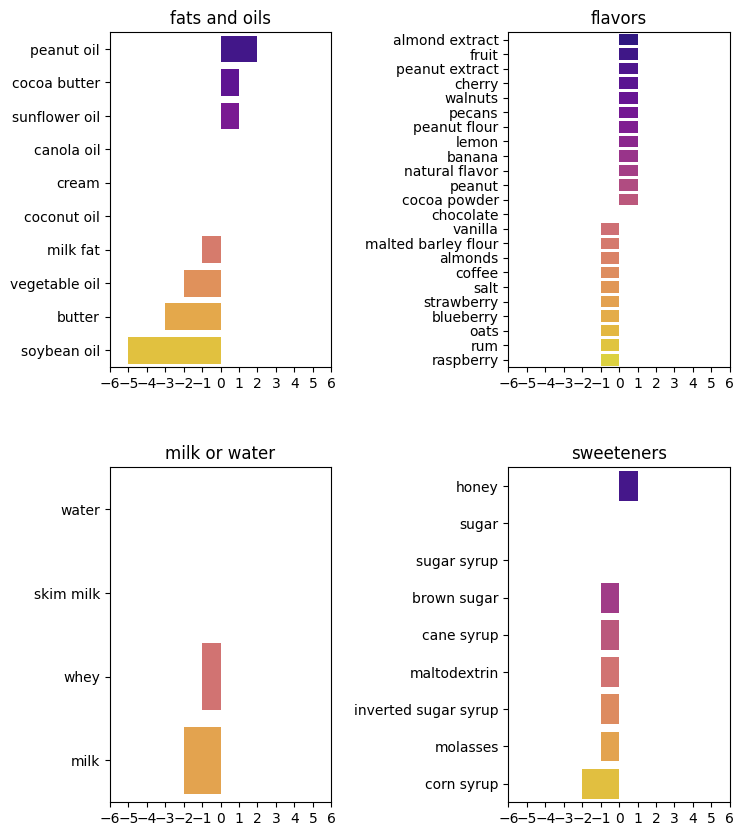

In [59]:
diff_graph_ingredients('BenJerrys', df)

HaagenDazs ingredient usage difference between top10 vs. bot10

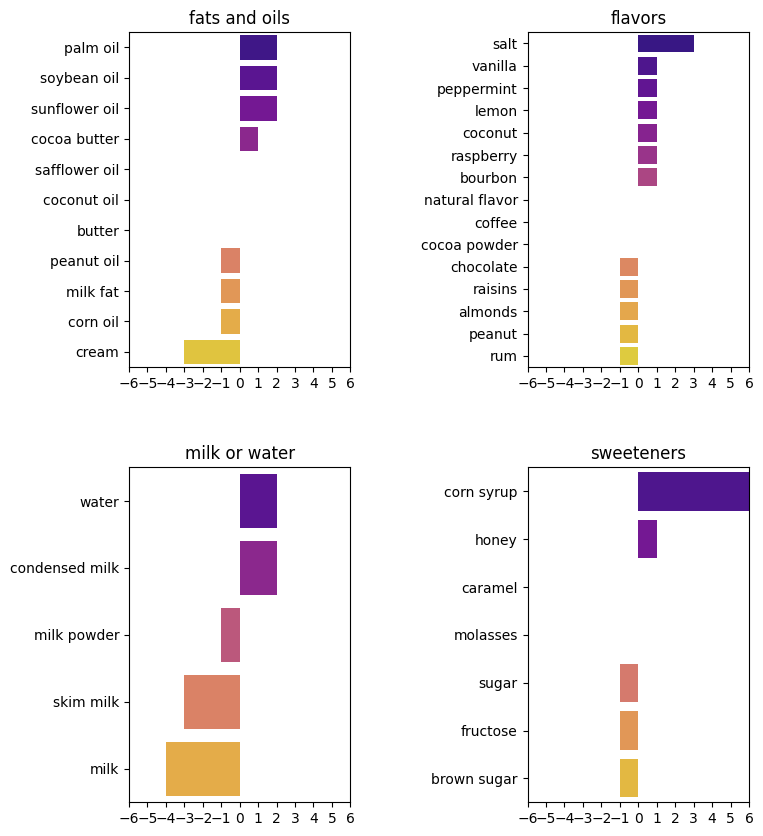

In [60]:
diff_graph_ingredients('HaagenDazs', df)

Breyers ingredient usage difference between top10 vs. bot10

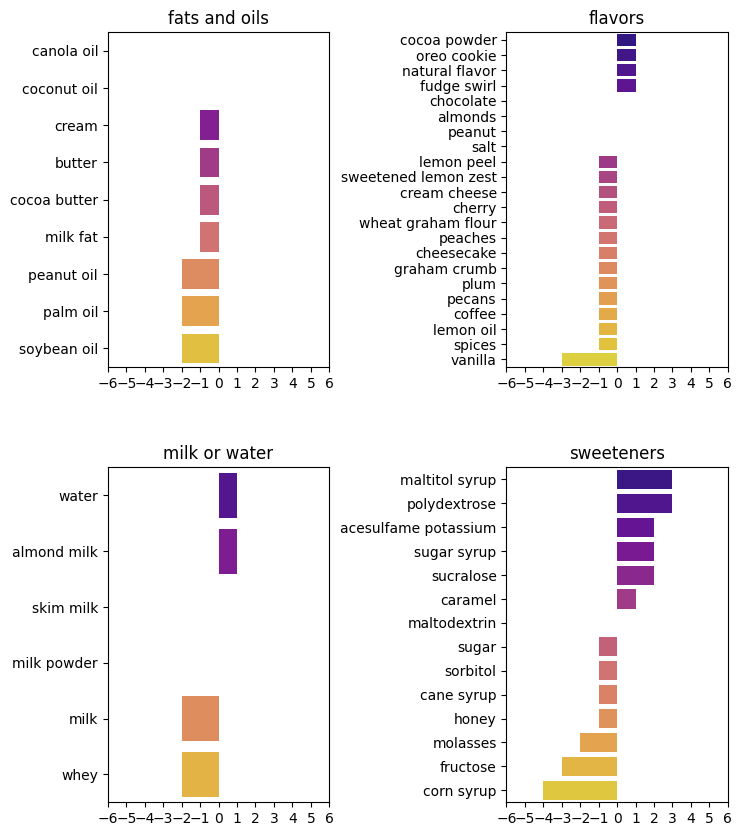

In [61]:
diff_graph_ingredients('Breyers', df)

Talenti ingredient usage difference between top10 vs. bot10

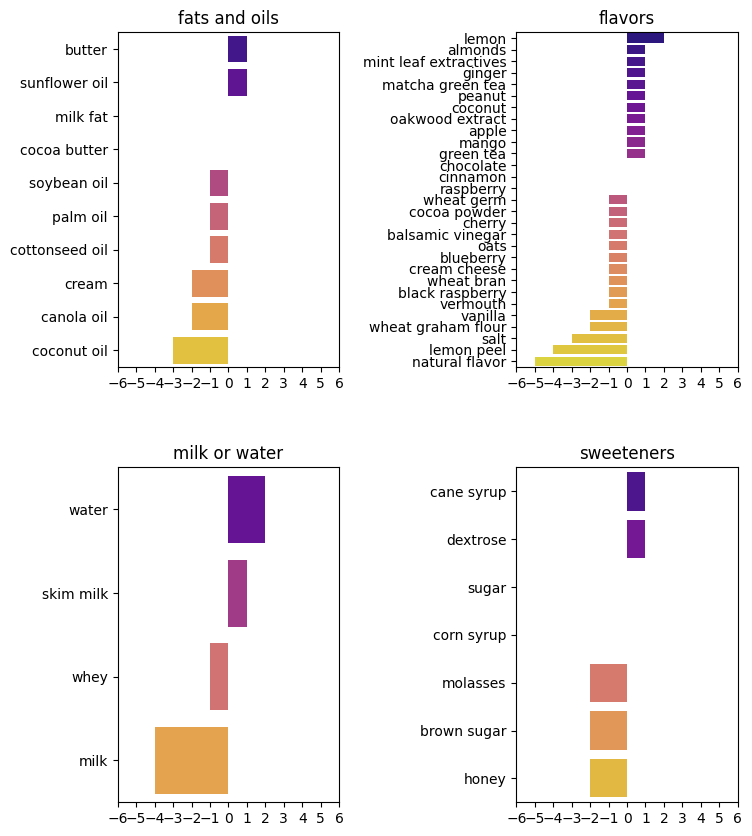

In [62]:
diff_graph_ingredients('Talenti', df)

In [63]:
table_tb10_all = compare_top10_and_bot10_ingredients('all', df, categories['flavors'])
table_tb10_bj = compare_top10_and_bot10_ingredients('BenJerrys', df, categories['flavors'])
table_tb10_hd = compare_top10_and_bot10_ingredients('HaagenDazs', df, categories['flavors'])
table_tb10_br = compare_top10_and_bot10_ingredients('Breyers', df, categories['flavors'])
table_tb10_tl = compare_top10_and_bot10_ingredients('Talenti', df, categories['flavors'])
table_tb10_br

,ingredient,top_count,bottom_count,diff
0,cocoa powder,6,5,1
1,oreo cookie,1,0,1
2,natural flavor,10,9,1
3,fudge swirl,1,0,1
4,chocolate,1,1,0
5,almonds,1,1,0
6,peanut,1,1,0
7,salt,6,6,0
8,lemon peel,0,1,-1
9,sweetened lemon zest,0,1,-1


In [64]:
df[df['brand'] == 'Breyers'].sort_values('rating', ascending=False).head(10)

,brand,name,rating,rating_count,ingredients_cleaned
213,Breyers,Oreo Snack Cups 10ct,5.0,2,"skim milk, sugar syrup, sugar, water, cream, corn syrup, corn syrup, oreo cookie, flour, wheat flour, niacin, reduced iron, thiamine mononitrate, riboflavin, folic acid, sugar, palm oil, canola oil, cocoa powder, corn syrup, leavening, baking soda, calcium phosphate, salt, soybean lecithin, chocolate, artificial flavor, whey, propylene glycol monoesters, monoglycerides, diglycerides, vegetable gum, natural flavor, cellulose gum, carrageenan, vitamin a palmitate"
202,Breyers,No Sugar Added Caramel Swirl,4.9,19,"milk, maltitol syrup, maltodextrin, cream, maltitol syrup, polydextrose, whey, coconut oil, butter, cream, salt, monoglycerides, diglycerides, vegetable gum, carob bean gum, guar gum, tara gum, salt, caramel, natural flavor, sucralose, soybean lecithin, acesulfame potassium, vitamin a palmitate, artificial color"
235,Breyers,Chocolate Snack Cups 10ct,4.9,26,"milk, cream, sugar, water, cocoa powder, whey, vegetable gum, natural flavor"
198,Breyers,Non-dairy Vanilla Peanut Butter,4.8,116,"almond milk, water, almonds, sugar syrup, sugar, water, peanut, coconut oil, corn syrup, pea protein, vegetable gum, carob bean gum, guar gum, monoglycerides, diglycerides, peanut oil, salt, natural flavor"
175,Breyers,Chocolate,4.7,225,"milk, cream, sugar, cocoa powder, whey, vegetable gum, natural flavor"
196,Breyers,Lactose Free Chocolate,4.7,24,"skim milk, sugar, corn syrup, cream, cocoa powder, whey, vegetable gum, carob bean gum, guar gum, tara gum, monoglycerides, diglycerides, salt, lactase, vitamin a palmitate, natural flavor"
237,Breyers,Carbsmart Caramel Swirl Bar,4.7,18,"milk, water, caramel, sugar, water, corn syrup, corn syrup, milk powder, butter, cream, salt, salt, molasses, pectin, soybean lecithin, natural flavor, potassium sorbate, sodium citrate, lactic acid, maltitol syrup, polydextrose, coconut oil, whey, glycerin, cream, soluble corn fiber, vegetable gum, carob bean gum, guar gum, caramel, monoglycerides, diglycerides, natural flavor, acesulfame potassium, sucralose"
212,Breyers,Carbsmart Mint Fudge Bar,4.6,20,"milk, water, fudge swirl, corn syrup, corn syrup, water, sugar, cocoa powder, cornstarch, natural flavor, salt, lactic acid, potassium sorbate, maltitol syrup, polydextrose, coconut oil, whey, glycerin, cream, soluble corn fiber, vegetable gum, carob bean gum, guar gum, monoglycerides, diglycerides, natural flavor, acesulfame potassium, artificial color, sucralose"
224,Breyers,Vanilla Chocolate,4.6,95,"milk, cream, sugar, whey, cocoa powder, vegetable gum, tara gum, carob bean gum, natural flavor"
233,Breyers,Natural Vanilla Snack Cups 10ct,4.6,28,"milk, cream, sugar, water, vegetable gum, natural flavor"


In [ ]:
#pd.options.display.max_rows = None
#pd.options.display.max_columns = None

[Bonus] step by step : Talenti example

In [65]:
#setting parameters
brand = 'Talenti'
ingredient_group = categories['flavors']
df = df.copy()

In [66]:
top10_tl, bot10_tl = parse_top_bot_ingredients(brand, df)

In [67]:
top10_tl

,brand,name,rating,rating_count,ingredients_cleaned
129,Talenti,Belgian Chocolate Gelato,4.8,27,"milk, sugar, cream, egg, egg yolk, dextrose, chocolate, cocoa powder, cocoa butter, chocolate, carob bean gum, soybean lecithin, natural flavor"
138,Talenti,Coconut Almond Chocolate Gelato,4.8,82,"milk, sugar, cream, chocolate, almonds, coconut, coconut, dextrose, coconut, soybean, sunflower oil, salt, carob bean gum, soybean lecithin, vanilla, natural flavor"
132,Talenti,Caramel Apple Pie Gelato,4.8,115,"milk, sugar, cream, dextrose, skim milk, wheat flour, cinnamon, apple, corn syrup, vanilla, carob bean gum, coconut oil, baking soda, egg, salt"
157,Talenti,Organic Oak-aged Vanilla Gelato,4.8,19,"skim milk, cream, sugar, dextrose, oakwood extract, carob bean gum, vanilla"
127,Talenti,Alphonso Mango Sorbetto,4.7,139,"mango, water, sugar, dextrose, lemon, carob bean gum"
165,Talenti,Salted Caramel Truffle,4.7,160,"milk, sugar, skim milk, cream, water, coconut oil, corn syrup, egg, egg yolk, cocoa powder, wheat flour, dextrose, palm oil, soybean oil, baking soda, vanilla, carob bean gum, sunflower lecithin, salt, soybean lecithin, natural flavor, cane syrup, cocoa powder, butter, guar gum, cornstarch, salt"
156,Talenti,Organic Ginger Matcha Gelato,4.7,21,"skim milk, cream, sugar, dextrose, ginger, matcha green tea, green tea, carob bean gum, vanilla, lemon"
159,Talenti,Peanut Butter Fudge Sorbetto,4.7,77,"water, peanut, sugar, dextrose, salt, cocoa powder, corn syrup, coconut oil, chocolate, cornstarch, salt, vanilla, carob bean gum, guar gum, xanthan gum"
164,Talenti,Roman Raspberry Sorbetto,4.7,161,"raspberry, water, sugar, dextrose, lemon, carob bean gum"
151,Talenti,Mediterranean Mint Gelato,4.7,324,"milk, sugar, cream, chocolate, dextrose, milk fat, cocoa butter, sunflower lecithin, carob bean gum, natural flavor, guar gum, chocolate, vanilla, soybean lecithin, mint leaf extractives"


In [68]:
bot10_tl

,brand,name,rating,rating_count,ingredients_cleaned
143,Talenti,Dark Chocolate Cherry,4.2,48,"milk, sugar, cream, egg yolk, egg white, chocolate, cocoa powder, coconut oil, dextrose, water, cherry, canola oil, vermouth, cherry, milk fat, cocoa butter, whey, lemon, vanilla, chocolate, carob bean gum, cocoa powder, soybean lecithin, salt, natural flavor"
144,Talenti,Dark Chocolate Sorbetto,4.2,41,"water, sugar, cocoa powder, dextrose, coconut oil, egg yolk, egg white, chocolate, carob bean gum, salt, natural flavor, pectin"
166,Talenti,Sea Salt Caramel Gelato,4.1,146,"milk, skim milk, sugar, cream, egg yolk, egg, corn syrup, coconut oil, dextrose, cocoa powder, salt, carob bean gum, vanilla, soybean lecithin, natural flavor"
130,Talenti,Black Raspberry Chocolate Chip Gelato,4.0,105,"milk, sugar, cream, black raspberry, dextrose, chocolate, coconut oil, carob bean gum, soybean oil, vanilla, soybean lecithin"
169,Talenti,Vanilla Blueberry Crumble Gelato,3.9,70,"milk, sugar, cream, tapioca, dextrose, oats, coconut oil, wheat flour, blueberry, vanilla, brown sugar, natural flavor, carob bean gum, vanilla, pectin, guar gum, artificial color, salt, citric acid, lemon peel"
150,Talenti,Madagascan Vanilla Bean Gelato,3.9,198,"milk, sugar, cream, dextrose, vanilla, sunflower lecithin, carob bean gum, guar gum, natural flavor, lemon peel"
163,Talenti,Raspberry Cheesecake Gelato,3.9,76,"milk, sugar, cream, cream cheese, corn syrup, flour, balsamic vinegar, egg, wheat graham flour, raspberry, vanilla, carob bean gum, modified cornstarch, palm oil, brown sugar, natural flavor, artificial color, carrageenan, honey, salt, soybean lecithin"
148,Talenti,Key Lime Pie Gelato,3.6,208,"milk, sugar, cream, dextrose, wheat flour, cottonseed oil, wheat graham flour, coconut oil, canola oil, carob bean gum, vanilla, palm oil, palm oil, wheat bran, honey, natural flavor, salt, molasses, soybean lecithin, wheat germ, cinnamon"
170,Talenti,Vanilla Caramel Swirl Gelato,3.6,38,"milk, sugar, cream, skim milk, dextrose, vanilla, corn syrup, carob bean gum, natural flavor, lemon peel, vanilla"
136,Talenti,Chocolate Chip Cookie Dough Gelato,2.8,104,"milk, sugar, cream, wheat flour, dextrose, skim milk, chocolate, vanilla, egg, cocoa powder, molasses, soybean oil, carob bean gum, rice flour, natural flavor, salt, cocoa butter, lemon peel, soybean lecithin"


In [69]:
diff_table_tl = compare_top10_and_bot10_ingredients('Talenti', df, categories['flavors'])
diff_table_tl

,ingredient,top_count,bottom_count,diff
0,lemon,3,1,2
1,almonds,1,0,1
2,mint leaf extractives,1,0,1
3,ginger,1,0,1
4,matcha green tea,1,0,1
5,peanut,1,0,1
6,coconut,1,0,1
7,oakwood extract,1,0,1
8,apple,1,0,1
9,mango,1,0,1


In [70]:
# saving these results in csv to medium gist files
eda_path = os.path.join(project_root, 'data', 'eda\\')

top10_tl.to_csv(eda_path + 'icecream2_top10_tl.csv', index=False, header=True, encoding='utf-8')
bot10_tl.to_csv(eda_path + 'icecream2_bot10_tl.csv', index=False, header=True, encoding='utf-8')
diff_table_tl.to_csv(eda_path + 'icecream2_diff_table_tl.csv', index=False, header=True, encoding='utf-8')